# XY-calibration (F2)

In [1]:
cd ..

/Users/Vincent/Github/FireBallPipe



| #  | Name                               | Done                     |       Comment               |
|----|------------------------------------|--------------------------|-----------------------------|
| 1  | Have a mask-detector mapping       | <input type="checkbox">  |  And send region file to zeren |
| 2  | Use the previous XY mapping        | <input type="checkbox">  | of the same mask, if never done do a new one   |
| 2.a  |Add mask rotation for F2       | <input type="checkbox">  |                             |
| 3  | Reset magnification/offset/angle   | <input type="checkbox">  |                             |
| 4  | Be sure of the slits path          | <input type="checkbox">  |  Use only regular slits, big moves, do not use slits that are seen with one line or in shadow   |
| 4.a  | Decide to use or not hysteresis compensation          | <input type="checkbox">  |  Adds ~1h in total + slight code complexity but might improve results by <1''  |
| 5  | Account from Zeren offset          | <input type="checkbox">  |                             |
| 6  | Add slits path in google drive     | <input type="checkbox">  |                             |
| 7  | Add CNES moves to google drive     | <input type="checkbox">  |                             |


In [2]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model, plot_fit
from guider2UV.MaskAstrometry import LocalScienceMaskProjector
from Calibration.mapping import Mapping

# encoder gains 2022:
CEg = 1.0187 # CEg = 1.02928 # 2018
Elg = 1.0090 # Elg = 1.00379 # 2018
print("After calibration of the encoders, El is %0.5f ''/inc and Ce is %0.5f ''/inc" %(Elg*0.092,CEg*0.01))


After calibration of the encoders, El is 0.09283 ''/inc and Ce is 0.01019 ''/inc


## initialization from last xy calib
---------------------------------
This was actually a mistake, it should slways be done from the same mask (same field center), or create a new G2UV object

In [3]:
# prerequisites:
Field = "F2"
previous_xy_mapping = "Calibration/Mappings/2018/XY/Guider2UV_F2_nogamma.new.pkl"
mask_det_map_file = "Calibration/Mappings/2022/mask_to_det_mapping/mapping-mask-det-w-2022-5-F2_21.pkl"
target_filename = 'Calibration/Targets/2022/targets_%s.csv'%(Field)
Hysteresis_compensation = False
# if input("Are you sure that you want to use Hysteresis_compensation = %s? (y/n)"%(Hysteresis_compensation))!="y":
#     raise ValueError("Please be verify the value of Hysteresis_compensation")


In [4]:
# load model from previous XY calib 
G2UV = Guider2UV(filename=previous_xy_mapping)

# eventually reset the guider-scmask rotation to 0 and magnification correction to 0.
G2UV.mask_rotation = 0.0*u.arcmin
G2UV.FieldP.gamma = 1. 
G2UV.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UV.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
print(G2UV)

# if you already know the approx angular distance between guidercenter and FOVcenter, set it:
#G2UV.FOV_center_guider_coord = coordinates.SkyCoord(delta_x*u.deg, # x guider axis (x axis in guider local frame, see XYcalib figure)
#                                                    delta_y*u.deg, # y guider axis (y axis guider local frame, see XYcalib figure)
#                                                    frame = G2UV.GuiderP.localframe)

# load targets
F1 = Table.read(target_filename, format='ascii')

# load mask-UVdetector mappings
mask_det_map = Mapping(mask_det_map_file)

# if input("Are you sure that these values make sense for %s: Theta=%s, center=%s? (y/n)"%(Field, G2UV.FieldP.rotation, G2UV.FieldP.center))!="y":
    # raise ValueError("Please verify the initialization mapping")



FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39837843, 36.42897653)>): (lon, lat) in deg
    (0.18293516, -0.01420325)>
FOV center pixel position in guider [array(1357.77258408), array(471.30507922)]

Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-20.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (253.0624, 34.9699)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39837843, 36.42897653)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.39837843  36.4289765325  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024600287745946  0.00024580474694405  
NAXIS : 0  0

    mask_rotation: 0.0 arcmin
    FOV c

## Alternative initialisation for new fields:
---------------------------------------

In [5]:

# f_ra, f_dec, f_rot = 0, 0, 0
# Field_center=coordinates.SkyCoord(f_ra * u.deg, f_dec * u.deg)
# # get FOVcenter & guider wcs from another field
# #  put pkl from a functionning mapping from another field
# G2UVother = Guider2UV(filename=previous_xy_mapping)
# FOVcenter = G2UVother.FOV_center_guider_coord
# guider_wcs = G2UVother.GuiderP.w
# G2UV = Guider2UV(Field_center=Field_center,
#                  Field_rotation= f_rot * u.deg,
#                  Field_gamma=1.0,  # platescale correction (need to update the polynomial in the MaskAstrometry.py)
#                  FOVcenter_guider_coord=FOVcenter,
#                  guider_wcs = guider_wcs,
#                  )
                 
# FNEW = Table.read(target_filename, format='ascii')
# mask_det_map = Mapping(mask_det_map_file)

# print(G2UV)

## 1-  Rotate mask carousel
## 2- Diffuse UV image

Copy the offset from [this spreadsheet step "Compute offsets with previous diffuse illumination image"](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [6]:
# This offset in X and Y should be positive if the slit position in tghe new image appears to be shifted towards the top right
diffuse_offset = np.array([2.88,2.88])
G2UV.set_detector_mapping(mask_det_map, offsets = diffuse_offset+1) #+1 offset is to account for DS9 vs python offset
direct_map = lambda w, x, y: mask_det_map.map(w, x, y) + diffuse_offset
inv_map = lambda w, x, y: mask_det_map.inv_map(w, x - diffuse_offset[0], y - diffuse_offset[1])

## 3 - Set guider at best focus          
## 4 - Align siderostat frames           
## 5 - Go to guider reference            
## 6 - Set UV/guider best focus offset   
## 7 - Rotate mask carousel              
## 8 - Through focus in UV               
## 9 - Note open-mask guider ref point   
    

## 10 - Go through the list of slits      


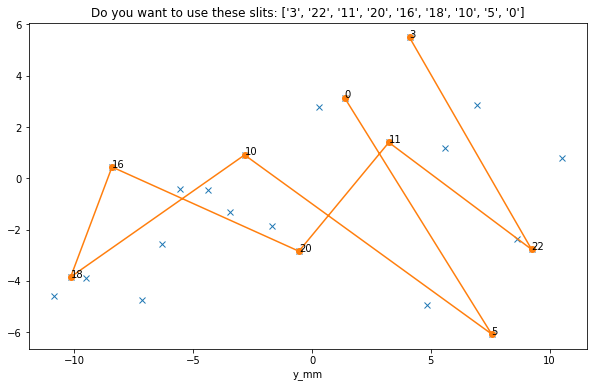

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance
str2,float64,float64,float64,float64,float64,float64,float64
3,4.1024263723571845,5.4922092173271935,253.25197,34.922949,512.196194559081,652.5266783203222,829.5396359671774
22,9.240203293510822,-2.7710198429850457,253.0784454345703,34.74169158935547,-159.25023042122808,-603.5476684570312,624.2038320846266
11,3.231739529930075,1.400442887423861,253.1322784423828,34.90934371948242,450.021149571787,-179.3792724609375,484.454289330302
20,-0.5529518044417673,-2.841283475857377,252.97984313964844,34.959171295166016,-33.08955769001426,-726.1001586914062,726.8537399503466
16,-8.4185196075882,0.4438571383060791,252.99105834960935,35.160865783691406,394.88243520181754,-14.29595947265625,395.1411293299667
18,-10.158457163246727,-3.8448914400392282,252.8568878173828,35.16483688354492,-595.1462984156786,447.9400634765625,744.8821497292513
10,-2.838628397312891,0.9121419991802835,253.05911254882807,35.040409088134766,255.3688062108002,1036.6287231445312,1067.6199402567331
5,7.555163383320225,-6.068029925869796,252.97247314453125,34.75245666503906,-558.0761371559746,-764.4360058593634,946.4731279424424
0,1.370426787508335,3.140090805285851,253.16115,34.9648,0.0,0.0,0.0


In [7]:
slits =['3', '22','11', '20', '16', '18', '10', '5',"0"]
F1['Internal-count'] = F1['Internal-count'].astype(str)
F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))
ra,dec = "RA", "DEC"
x,y = "x_mm","y_mm"
plt.figure(figsize=(10,6))
plt.plot(F1[x],F1[y],"x")
plt.plot(selected_slits[x],selected_slits[y],"-o")
for s in selected_slits:
    plt.text(s[x],s[y],s["Internal-count"])
plt.xlabel("x_mm")
plt.xlabel("y_mm")
plt.title("Do you want to use these slits: %s"%(slits))
plt.show()

selected_slits = selected_slits['Internal-count',x,y,ra,dec]
slit_path = selected_slits# vstack((selected_slits,selected_slits[::-1]) )
slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path

The slits table has been copied. Add it to the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [8]:
moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])#,dtype=[("EL",float),("CE",float),("UV_image",float)])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves.to_clipboard()
moves 
if ~Hysteresis_compensation:
    print("Carefull, with Hysteresis_compensation==%s the last move to return to the guider is not given. You just need to do -∑all moves"%(Hysteresis_compensation))
    print("You should then add EL=%0.4f and CE=%0.4f"%(moves.sum(axis=0)[0],moves.sum(axis=0)[1]))


slit position in mm on mask: [4.10242637 5.49220922]
slit position in mm on mask: [ 9.24020329 -2.77101984]
slit position in mm on mask: [3.23173953 1.40044289]
slit position in mm on mask: [-0.5529518  -2.84128348]
slit position in mm on mask: [-8.41851961  0.44385714]
slit position in mm on mask: [-10.15845716  -3.84489144]
slit position in mm on mask: [-2.8386284  0.912142 ]
slit position in mm on mask: [ 7.55516338 -6.06802993]
slit position in mm on mask: [1.37042679 3.14009081]

targets local coords in siderostat local frame:
EL: 561.1 arcsec ; CE: 194.6 arcsec
EL: 210.5 arcsec ; CE: 407.2 arcsec
EL: 387.5 arcsec ; CE: 158.6 arcsec
EL: 207.5 arcsec ; CE: 2.0 arcsec
EL: 346.9 arcsec ; CE: -323.5 arcsec
EL: 164.9 arcsec ; CE: -395.5 arcsec
EL: 366.7 arcsec ; CE: -92.6 arcsec
EL: 70.6 arcsec ; CE: 337.5 arcsec
EL: 461.3 arcsec ; CE: 81.5 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)
Carefull, with Hysteresis_compensation==False

The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Copy below the observed slits position from the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [9]:
slits_coord_obs_det = np.array([
[ 2020.5	, 808.5    ],
[ 1475.5	, 437.5   ],
[ 1747.6	, 880.5   ],
[ 1468.5	, 1170.5   ],
[ 1689.4	, 1757.5   ],
[ 1410.5	, 1894.5   ],
[ 1715.6	, 1338.6   ],
[ 1257  	, 565.5   ],
[ 1862.5	, 1018.6   ]]) 

valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave =  0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs

if input("Are you sure you computed the barycenter on the line %s? Remember that it's better to use 206 line to probe a bigger part of the detector. It might require gain and longer exposure though. Be sure to always compute the centroid on the same line. (y/n)"%(obs_wave))!="y":
    raise ValueError("Please change obs_wave parameter (c)")


wave:  0.20619


### look at siderostat frame hysteresis 

In [10]:
if Hysteresis_compensation:
    mid  = len(slits_coord_obs_det)//2
    pair_diff = slits_coord_obs_det[:mid] - slits_coord_obs_det[::-1][:mid]
    moves_sign  = np.sign(moves[2:mid+2])
    pair_diff_signed = pair_diff * moves_sign
    valid = np.arange(len(moves_sign))#[0,2,3,4]
    fig, (ax0,ax1) = plt.subplots(1,2)
    ax0.plot(pair_diff_signed[valid,0],'*-')
    ax0.set_title("El pair diff")
    ax0.set_ylabel("El arcsec")
    ax1.plot(pair_diff_signed[valid,1],'*-')
    ax1.set_title("Ce pair diff")
    ax1.set_ylabel("Ce arcsec")
    fig.suptitle("Hysteresis analysis")
    fig.tight_layout()


## 11- Note open-mask guider ref point
## 12- Update model with observed slit positions

Fitting rotation, translation and magnification
gamma: 1.0303679573824258
theta: 93.02009851001213 arcmin
dx: -51.174012973028226 arcsec
dy: -80.36892076488522 arcsec
variances: [5.82760715e-04 2.00338377e+00 4.80302061e-01 4.80302061e-01]

residuals in arcsec: [[  2.92070046   2.69489275]
 [ -0.18382645  -1.6417097 ]
 [ -1.59151476   1.34956207]
 [ 14.79118591   1.13242562]
 [-12.74625027  -6.15805389]
 [ -0.19521804   1.10428973]
 [ -4.40865499   1.93021778]
 [  1.41357813  -0.41162436]]
max residual in EL,CE 14.8, 6.2 arcsec
mean residual in EL,CE 7.2, 2.6 arcsec


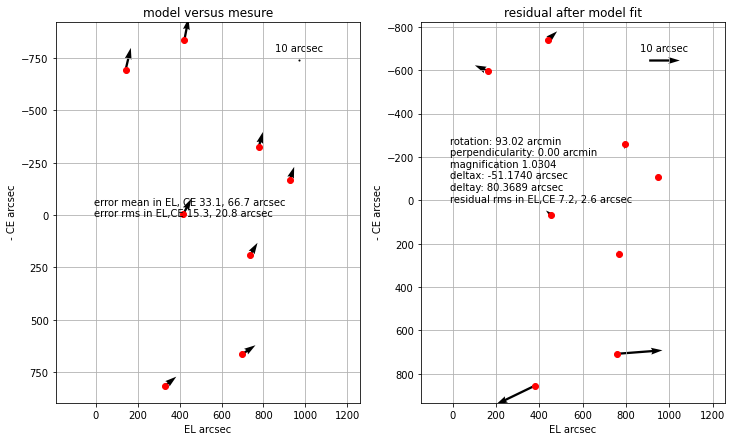

After updating:
    mask_rotation: 93.02009851001213 arcmin
    FOV center in guider: 1327.4909396270714 x 401.27168153775 pix = 628.775418164106 arcsec x -115.23358748701273 arcsec arcsec
    mask_magnification correction: 1.0303679573824258  
    


In [10]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True, figsize=(12,7))#, labels=slits_valid


### check updating without fitting magnification

In [16]:
G2UVtest=G2UV.copy()
G2UVtest.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UVtest.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
G2UVtest.FieldP.gamma = 1.
print(G2UVtest)


Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (32.19, -5.688)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.392728151  36.4185638082  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024551548564194  0.00024661678545423  
NAXIS : 0  0

    mask_rotation: 0.0 arcmin
    FOV center in guider: 1378.693979871492x218.8622925672349 pix



Fitting rotation, translation and magnification
gamma: 1.0232833033079378
theta: -2.0637580783996947 arcmin
dx: 4.437276448568153 arcsec
dy: 143.25463394034085 arcsec
variances: [6.11843078e-04 2.10336157e+00 5.00674651e-01 5.00674651e-01]

residuals in arcsec: [[  1.9657011   -1.71084236]
 [ -0.01330166   2.84150477]
 [ -7.2949686    6.7729117 ]
 [  2.47269373  -3.13469606]
 [  2.4098009    3.81370921]
 [ -5.181121     3.22448209]
 [  5.64119552 -11.80706935]]
max residual in EL,CE 7.3, 11.8 arcsec
mean residual in EL,CE 4.3, 5.7 arcsec


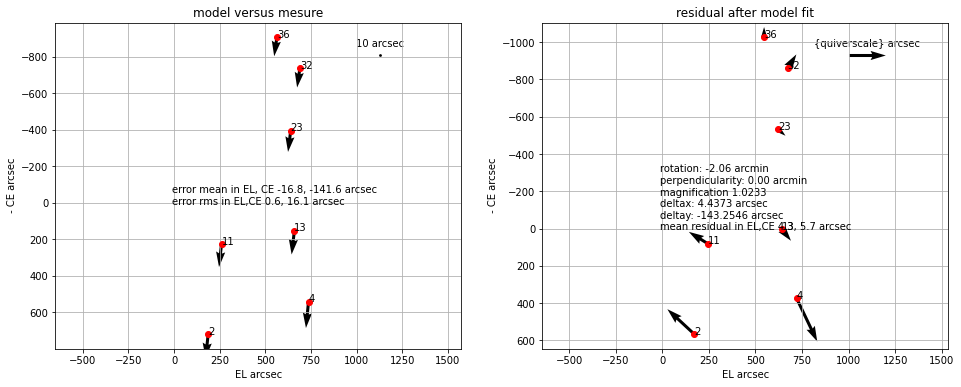

After updating:
    mask_rotation: -2.0637580783996947 arcmin
    FOV center in guider: 1398.4762460299144 x 365.8956797724491 pix = 690.9515191289703 arcsec x -162.34450625985818 arcsec arcsec
    mask_magnification correction: 1.0232833033079378  
    


In [17]:
G2UVcor_test, residuals = G2UVtest.update_model(slits_coord_valid, slits_coord_obs, labels=slits, plot=True, figsize=(16,6), gamma=True)


### save corrected model for future use (eg redo the calib on same field)

In [11]:
G2UVcor.save(filename="Calibration/Mappings/2022/XY/F2_XY_220718.pkl")

Dumping to Calibration/Mappings/2022/XY/F2_XY_220718.pkl


## 13 - Rotate carousel to science mask
## 14 - Note open-mask guider ref point
## 15 - Check corrected model through science mask

In [31]:
moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves.to_pandas().to_clipboard()
moves

new_cat = slit_path[:6]
new_cat["EL"] = moves["EL"][1:]
new_cat["CE"] = moves["CE"][1:]

new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg 
new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg 
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
# new_cat.to_pandas().to_clipboard()

plt.figure()
plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
plt.legend()
plt.show()
new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"


slit position in mm on mask: [4.10242637 5.49220922]
slit position in mm on mask: [ 9.24020329 -2.77101984]
slit position in mm on mask: [3.23173953 1.40044289]
slit position in mm on mask: [-0.5529518  -2.84128348]
slit position in mm on mask: [-8.41851961  0.44385714]
slit position in mm on mask: [-10.15845716  -3.84489144]
slit position in mm on mask: [-2.8386284  0.912142 ]
slit position in mm on mask: [ 7.55516338 -6.06802993]
slit position in mm on mask: [1.37042679 3.14009081]

targets local coords in siderostat local frame:
EL: 555.5 arcsec ; CE: 227.0 arcsec
EL: 201.8 arcsec ; CE: 458.4 arcsec
EL: 376.3 arcsec ; CE: 194.2 arcsec
EL: 187.3 arcsec ; CE: 36.0 arcsec
EL: 321.0 arcsec ; CE: -307.0 arcsec
EL: 132.1 arcsec ; CE: -377.4 arcsec
EL: 347.9 arcsec ; CE: -66.8 arcsec
EL: 56.2 arcsec ; CE: 389.6 arcsec
EL: 449.8 arcsec ; CE: 111.9 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


ValueError: Inconsistent data column lengths

The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Here we just wanted to do another try to verify that the least square gives consistent results

Fitting rotation, translation and magnification
gamma: 0.9913145147669453
theta: 2.3928066940758446 arcmin
dx: 13.08902843092678 arcsec
dy: -2.3286569466639366 arcsec
variances: [5.82760715e-04 2.00338377e+00 4.80302061e-01 4.80302061e-01]

residuals in arcsec: [[ 5.9552577   2.11206419]
 [-0.28361155 -1.40803643]
 [ 4.03303664  1.00410464]
 [ 3.68529213 -1.35814873]
 [-2.79814471  0.24194229]
 [-2.30644101  1.49634587]
 [-5.87808213 -1.00817901]
 [-2.40730708 -1.08009281]]
max residual in EL,CE 6.0, 2.1 arcsec
mean residual in EL,CE 3.9, 1.3 arcsec


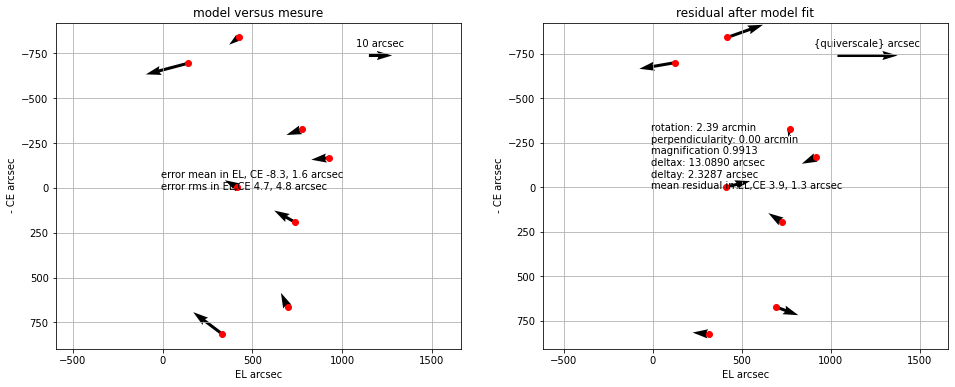

After updating:
    mask_rotation: 95.41290520408798 arcmin
    FOV center in guider: 1335.649176100541 x 400.0544960027155 pix = 636.4834340858067 arcsec x -116.12373243889097 arcsec arcsec
    mask_magnification correction: 1.0214187117039681  
    


(<guider2UV.guider2UV.Guider2UV at 0x7f80310c44f0>,
 array([[ 1.65423825e-03,  5.86684497e-04],
        [-7.87809865e-05, -3.91121232e-04],
        [ 1.12028796e-03,  2.78917955e-04],
        [ 1.02369226e-03, -3.77263536e-04],
        [-7.77262419e-04,  6.72061906e-05],
        [-6.40678058e-04,  4.15651632e-04],
        [-1.63280059e-03, -2.80049726e-04],
        [-6.68696411e-04, -3.00025781e-04]]))

In [32]:
slits_coord_obs_det = np.array([
[ 2009.5,	752.5      ],
[ 1460.2,	345.5     ],
[ 1728.5,	816.5      ],
[ 1435.5	,1108.5      ],
[ 1647.4	,1727.6      ],
[ 1358.5	,1862.5      ],
[ 1684.5	,1292.5      ],
[ 1232.5,	470.5      ],
[ 1842.6,	963.5      ]]) 

slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
G2UVcor.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True, figsize=(16,6))#, labels=slits_valid





## 16 - Note science-mask guider ref point
## 17 - Go through the Star sequence 
[36, 40, 46, 21 ]
we did not have the time to do this because G2UV was not well

In [12]:
star_target_path = "Calibration/Targets/2022/GuidingStars/F2_guidingstars.fits"
# il faut que le centre soit bien defini à l'arcseconde pres.
F1_stars = Table.read(star_target_path, format='fits').to_pandas()

stars =[36, 40, 46, 21 ]
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()



# stars_path = vstack((selected_stars,selected_stars[::-1]) )
# selected_stars['lon'] = [s.lon.deg*3600 for s in stars_coord]
# selected_stars['lat'] =  [s.lat.deg*3600 for s in stars_coord]
# print("(They have been copied to clipboard, paste it in the spreadsheet)")
# star_moves.to_clipboard()
# star_moves




targets local coords in siderostat local frame:
EL: 26.4 arcsec ; CE: 138.3 arcsec
EL: -75.9 arcsec ; CE: 176.1 arcsec
EL: -160.1 arcsec ; CE: 196.9 arcsec
EL: -24.5 arcsec ; CE: -9.9 arcsec

siderostat moves sequence: 


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [14]:
selection = selected_stars['Internal count',
 'RA',
 'DEC',
 'X',
 'Y',
 'GAIA gband',
 'SDSS gband',
 'SDSS rband',
 'Xguider',
 'Yguider']
# selection=vstack((selection,selection[::-1]))
selection.add_row(["-99",-99,-99,640,540,-99,-99,-99,-99,-99])
selection.to_pandas().to_clipboard()
selection

Internal count,RA,DEC,X,Y,GAIA gband,SDSS gband,SDSS rband,Xguider,Yguider
int64,float64,float64,float64,float64,int64,int64,int64,float64,float64
36,252.895501,34.875333,1.782545,-6.849765,--,12,11,731.8433190865437,310.93065953895103
40,252.83754,34.836825,2.6253,-9.313751,12,--,--,496.23595390816087,226.44855118488908
46,252.787662,34.810634,3.071645,-11.333377,9,10,--,298.1291527029413,177.65119520514313
21,252.829951,34.945769,-1.818564,-7.966884,--,13,12,624.055647571784,655.6639948807849
-99,-99.0,-99.0,640.0,540.0,-99,-99,-99,-99.0,-99.0


The stars table has been copied. Add it to the [stars tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)


## 18 - Through focus guide star 1
## 19 - Track mask to guider changes
------------------------------------------------------